# Aula 03: Naive Bayes e k-NN

**Índice**:

- [Aula 03: Naive Bayes e k-NN](#Aula-03:-Naive-Bayes-e-k-NN)
  - [Configurações](#Configurações)
  - [Naive Bayes categórico](#Naive-Bayes-categórico)
    - [Exploração inicial](#Exploração-inicial)
    - [Pré-processando os dados](#Pré-processando-os-dados)
    - [Treinando seu primeiro modelo](#Treinando-seu-primeiro-modelo)
    - [Calculando o erro empírico](#Calculando-o-erro-empírico)
  - [k-NN](#k-NN)
    - [Carregando os dados](#Carregando-os-dados)
    - [Exploração dos dados](#Exploração-dos-dados)
    - [Treinando o k-NN e calculando o erro empírico... *wait, what*?](#Treinando-o-k-NN-e-calculando-o-erro-empírico...-wait,-what?)
  - [Separação em treino e teste](#Separação-em-treino-e-teste)

## Configurações

Especifique o diretório onde os arquivos de dados podem ser encontrados:

In [1]:
DATA_DIR = '/home/mariohn/Documentos/VSCODE/Datasets/'

Importa bibliotecas:

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import load_iris

## Naive Bayes categórico

O scikit-learn implementa diferentes modelos de classificação baseados em probabilidades no módulo `sklearn.naive_bayes`. Eles se diferem pela forma como calculam as probabilidades dos atributos.

O Naive Bayes categórico é implementado pela classe `sklearn.naive_bayes.CategoricalNB`. Por exemplo, para estimar a verossimilhança, ele usa a seguinte fórmula,

$$p(x|y) = \frac{N_x+\alpha}{N_y+\alpha{}n_i},$$

na qual as variáveis representam o seguinte:

- $N_x$ é o número de exemplos da classe $y$ que possuem o valor $x$ para o atributo em questão;
- $N_y$ é o número de exemplos da classe $y$;
- $\alpha$ é um fator de ajuste;
- $n_i$ é o número de valores distintos que o atributo em questão pode assumir.

Tomando o conjunto `play_tennis` como exemplo, tínhamos o seguinte:

- Havia 9 instâncias da classe `sim` no conjunto de treinamento;
- O atributo `aparencia` possuía três possíveis valores: `ensolarado`, `nublado` e `chuvoso`;
- Das 9 instâncias da classe `sim`, duas possuem valor `ensolarado`.

Nesse caso, a verossimilhança do valor `ensolarado` seria calculada da seguinte maneira:

$$p(\textsf{ensolarado}|\textsf{sim})=\frac{2+\alpha}{9+3\alpha}$$

Isso se chama suavização de Laplace e serve para resolver problemas que podem acontecer quando um exemplo possui um valor que não estava presente no conjunto de treinamento.

### Exploração inicial

Vamos começar importando esta classe.

In [3]:
from sklearn.naive_bayes import CategoricalNB

Como no problema `play_tennis` todas as categorias ocorrem para todos os exemplos pelo menos uma vez, não há possibilidade de um exemplo de inferência conter valores novos. Portanto podemos especificar um valor bem pequeno para esse hiperparâmetro—por exemplo, $\alpha=1\times10^{-10}$.

**TODO**: instancie um objeto da classe CategoricalNB com o nome `nb` e parâmetro `alpha=1e-10`.

In [4]:
# instancie aqui 
nb = CategoricalNB(alpha=1e-10)

Se você fez corretamente, então a célula abaixo deverá produzir a saída `CategoricalNB(alpha=1e-10)`.

In [5]:
nb

CategoricalNB(alpha=1e-10)

Agora, vamos carregar os dados. Os dados da base `playtennis` estão em um arquivo CSV. O jeito mais fácil de ler um arquivo CSV é por por meio do Pandas.

In [6]:
tennis = pd.read_csv(DATA_DIR + 'tennis.csv')

In [7]:
tennis

,aparencia,temperatura,umidade,vento,jogar
0,ensolarado,quente,alta,fraco,nao
1,ensolarado,quente,alta,forte,nao
2,nublado,quente,alta,fraco,sim
3,chuvoso,moderado,alta,fraco,sim
4,chuvoso,frio,baixa,fraco,sim
5,chuvoso,frio,baixa,forte,nao
6,nublado,frio,baixa,forte,sim
7,ensolarado,moderado,alta,fraco,nao
8,ensolarado,frio,baixa,fraco,sim
9,chuvoso,moderado,baixa,fraco,sim


O CSV é lido em um objeto da classe `DataFrame`, que é um dado estruturado. Seu comportamento é equivalente ao de uma matriz que possui dois índices.

Eis o índice das colunas...

In [8]:
tennis.columns

Index(['aparencia', 'temperatura', 'umidade', 'vento', 'jogar'], dtype='object')

...e o índice das linhas.

In [9]:
tennis.index

RangeIndex(start=0, stop=14, step=1)

Se você utilizar o operador sobrecarregado `[]`, você pode acessar uma coluna por meio de sua chave no índice. Por exemplo.

**TODO**: acesse a coluna `aparencia` por meio do operador sobrecarregado `[]`

*DICA*: indexe o `DataFrame` como se fosse um dicionário.

*SAÍDA*: se você fizer corretamente, então a célula deverá produzir como saída uma série que possui linhas numeradas de 0 a 13 e os valores do atributo `aparencia`.

In [10]:
tennis['aparencia']

0     ensolarado
1     ensolarado
2        nublado
3        chuvoso
4        chuvoso
5        chuvoso
6        nublado
7     ensolarado
8     ensolarado
9        chuvoso
10    ensolarado
11       nublado
12       nublado
13       chuvoso
Name: aparencia, dtype: object

Quando você acessa uma coluna ou uma linha em um `DataFrame`, o resultado é um objeto da classe `Series`, também do Pandas.

Se o `DataFrame` é uma matriz com dois índices, então o objeto `Series` é um vetor com um único índice. No caso do acesso às colunas, o índice da série é o índice das linhas do `DataFrame`.

Além do acesso implícito por meio do operador sobrecarregado `[]`, o `DataFrame` permite acecssar de maneira explícita o índice `iloc`, que é puramente posicional, e o índice `loc`, que usa chaves para encontrar as linhas e as colunas.

**TODO:** acesse a coluna `temperatura` por meio do índice `loc`.

*DICA*: selecione todas as linhas e a coluna `temperatura` com o fatiamento `[:, 'temperatura']`

In [11]:
tennis.loc[:, 'temperatura']

0       quente
1       quente
2       quente
3     moderado
4         frio
5         frio
6         frio
7     moderado
8         frio
9     moderado
10    moderado
11    moderado
12      quente
13    moderado
Name: temperatura, dtype: object

**TODO**: acesse os cinco primeiros exemplos da terceira coluna (`vento`) por meio do índice `iloc`.

*DICA*: selecione as cinco primeiras linhas no fatiamento com `:5` e especifique a terceira coluna pelo seu índice.

In [12]:
tennis.loc[:5, 'vento']

0    fraco
1    forte
2    fraco
3    fraco
4    fraco
5    forte
Name: vento, dtype: object

Existem algumas situações particulares em que o uso específico de um índice é recomendável. De maneira geral, sempre que você quiser alterar dados em um `DataFrame`, é aconselhável usar o índice `loc` ou `iloc` explicitamente.

Você poder ler mais sobre isso na documentação do Pandas:  https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

### Pré-processando os dados

Agora vamos treinar o classificador e gerar um modelo. A primeira coisa a se fazer é separar as características dos exemplos dos rótulos. Faça isso com fatiamento e o índice `iloc`.

**TODO:** copie todas as colunas, exceto a última, para uma variável `X` e apenas a última coluna para uma variável `y`. Lembre-se que a última coluna pode ser acessada com o índice `-1` e que uma fatia com as colunas $[a,b)$ pode ser obtida por `a:b`.

In [13]:
X = tennis.iloc[:, :4]
y = tennis.iloc[:, 4:]


Se você fez corretamente para `X`, então na célula abaixo devem aparecer os valores dos 4 atributos para 14 exemplos...

In [14]:
X

,aparencia,temperatura,umidade,vento
0,ensolarado,quente,alta,fraco
1,ensolarado,quente,alta,forte
2,nublado,quente,alta,fraco
3,chuvoso,moderado,alta,fraco
4,chuvoso,frio,baixa,fraco
5,chuvoso,frio,baixa,forte
6,nublado,frio,baixa,forte
7,ensolarado,moderado,alta,fraco
8,ensolarado,frio,baixa,fraco
9,chuvoso,moderado,baixa,fraco


...e na célula abaixo devem aparecer 14 valores de classes.

In [15]:
y

,jogar
0,nao
1,nao
2,sim
3,sim
4,sim
5,nao
6,sim
7,nao
8,sim
9,sim


Agora vamos treinar o modelo. De maneira geral, as classes do scikit-learn usam a interface `fit`/`predict` ou a interface `fit`/`transform`. Primeiro algum ajuste aos dados é feito com o método `fit()`. Depois realiza-se inferência com `predict()` ou, no caso de processadores, transformação de dados com `transform()`.

Entretanto, uma particularidade do scikit-learn é que, geralmente, os modelos só trabalham com valores numéricos. Mesmo no caso do Naive Bayes categórico, é preciso que os valores categóricos que representamos com *strings* sejam convertidos em números discretos.

Isso pode ser feito, por exemplo, com a class `OrdinalEncoder`.

In [16]:
from sklearn.preprocessing import OrdinalEncoder

Vamos começar criando um codificador para as características armazenadas em `X`.

In [17]:
tennis_oe = OrdinalEncoder()
petal_oe = OrdinalEncoder()

In [18]:
tennis_oe.fit(X)

OrdinalEncoder()

Agora, aplique a transformação aos exemplos originais, produzindo uma nova versão da matriz `X`.

**TODO:** Aplique o método `transform` do codificador aos exemplos de `X`. Não sobrescreva a variável `X` com os novos dados. Em vez disso, guarde os dados transformados em uma variável `Xenc`.

In [19]:
Xenc = tennis_oe.transform(X)
Xenc

array([[1., 2., 0., 1.],
       [1., 2., 0., 0.],
       [2., 2., 0., 1.],
       [0., 1., 0., 1.],
       [0., 0., 1., 1.],
       [0., 0., 1., 0.],
       [2., 0., 1., 0.],
       [1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [0., 1., 1., 1.],
       [1., 1., 1., 0.],
       [2., 1., 0., 0.],
       [2., 2., 1., 1.],
       [0., 1., 0., 0.]])

Se você fez corretamente, então a célula abaixo deve fazer a transformação inversa sem erros. O resultado será um vetor NumPy contendo os mesmos valores do `DataFrame` original.

In [20]:
tennis_oe.inverse_transform(Xenc)

array([['ensolarado', 'quente', 'alta', 'fraco'],
       ['ensolarado', 'quente', 'alta', 'forte'],
       ['nublado', 'quente', 'alta', 'fraco'],
       ['chuvoso', 'moderado', 'alta', 'fraco'],
       ['chuvoso', 'frio', 'baixa', 'fraco'],
       ['chuvoso', 'frio', 'baixa', 'forte'],
       ['nublado', 'frio', 'baixa', 'forte'],
       ['ensolarado', 'moderado', 'alta', 'fraco'],
       ['ensolarado', 'frio', 'baixa', 'fraco'],
       ['chuvoso', 'moderado', 'baixa', 'fraco'],
       ['ensolarado', 'moderado', 'baixa', 'forte'],
       ['nublado', 'moderado', 'alta', 'forte'],
       ['nublado', 'quente', 'baixa', 'fraco'],
       ['chuvoso', 'moderado', 'alta', 'forte']], dtype=object)

Precisamos fazer a mesma coisa para a classe. Entretanto, a classe `OrdinalEncoder` só trabalha com matrizes e `DataFrames`. Para discretizar uma série ou um vetor, usamos a classe `LabelEncoder`.

A interface é essencialmente a mesma... Aqui estão os primeiros passos:

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
tennis_le = LabelEncoder()
petal_le = LabelEncoder()

**TODO:** use `fit()` para aprender a codificar os rótulos dos exemplos.

In [23]:
tennis_le.fit(y)

/home/mariohn/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

**TODO:** use `transform()` para gerar uma nova versão, discretizada, dos rótulos. Guarde o resultado em `yenc`.

In [24]:
yenc = tennis_le.transform(y)
yenc

/home/mariohn/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Se você fez corretamente, a célula abaixo deverá produzir de volta os valores das classes.

In [25]:
tennis_le.inverse_transform(yenc)

array(['nao', 'nao', 'sim', 'sim', 'sim', 'nao', 'sim', 'nao', 'sim',
       'sim', 'sim', 'sim', 'sim', 'nao'], dtype=object)

### Treinando seu primeiro modelo

Agora que você carregou e discretizou os dados, finalmente é hora de treinar seu primeiro modelo!

Para isso, basta aplicar `fit()`, passando como argumento as características e as classes.

**TODO:** treine o modelo com `nb.fit()`.

In [26]:
nb.fit(Xenc, yenc)

CategoricalNB(alpha=1e-10)

Agora vamos discretizar o exemplo do dia 15 que vimos em aula.

In [27]:
dia15 = tennis_oe.transform([['ensolarado', 'moderado', 'alta', 'forte']])

/home/mariohn/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [28]:
dia15

array([[1., 1., 0., 0.]])

**TODO:** faça previsão da classe do exemplo do dia 15 utilizando o método `nb.predict()`.

*SAÍDA*: deve ser previsto como a classe 0.

In [29]:
nb.predict(dia15)

array([0])

Para confirmar a saída, você pode usar o codificador `tennis_le` e aplicar uma transformada inversa à saída do `nb.predict()`.

In [30]:
tennis_le.inverse_transform(nb.predict(dia15))

array(['nao'], dtype=object)

### Calculando o erro empírico

O erro empírico é a estimativa do desempenho do classificador obtida no próprio conjunto de treinamento. Primeiro, obtenha a previsão do modelo para todos os exemplos de treinamento com `nb.predict()`. Guarde o resultado em uma variável chamada `ypred`.

$$ \frac{1 - N_c}{N} $$ 

$$ \frac{Nc}{N} $$

**TODO:** faça previsão do próprio conjunto de treinamento com `nb.predict()` e guarde o resultado em uma variável chamada `ypred`.

In [31]:
ypred = nb.predict(Xenc)
ypred

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

Se você fez corretamente, então a célula a seguir deverá mostrar os rótulos que foram previstos.

In [32]:
tennis_le.inverse_transform(ypred)

array(['nao', 'nao', 'sim', 'sim', 'sim', 'sim', 'sim', 'nao', 'sim',
       'sim', 'sim', 'sim', 'sim', 'nao'], dtype=object)

E a seguir você deverá ver, lado a lado, os exemplos originais e os rótulos que foram previstos.

In [33]:
tc = tennis.copy()
tc['pred'] = tennis_le.inverse_transform(ypred)
tc

,aparencia,temperatura,umidade,vento,jogar,pred
0,ensolarado,quente,alta,fraco,nao,nao
1,ensolarado,quente,alta,forte,nao,nao
2,nublado,quente,alta,fraco,sim,sim
3,chuvoso,moderado,alta,fraco,sim,sim
4,chuvoso,frio,baixa,fraco,sim,sim
5,chuvoso,frio,baixa,forte,nao,sim
6,nublado,frio,baixa,forte,sim,sim
7,ensolarado,moderado,alta,fraco,nao,nao
8,ensolarado,frio,baixa,fraco,sim,sim
9,chuvoso,moderado,baixa,fraco,sim,sim


O scikit possui a função `sklearn.metrics.accuracy_score` que calcula uma medida chamada acurácia. A  acurácia nada mais é do que o valor complementar do erro. Ou seja, `erro = 1 - acurácia`.

In [34]:
from sklearn.metrics import accuracy_score

**TODO:** Calcule o erro empírico, chamando a função `accuracy_score` com os rótulos verdadeiros e os rótulos previstos.

*SAÍDA*: o resultado deve ser 0.9286

In [35]:
accuracy_score(yenc, ypred)

0.9285714285714286

## k-NN

O classificador k-Vizinhos-Mais-Próximos está implementado na classe `sklearn.neighbors.KNeighborsClassifier`. Ele é baseado na regra dos vizinhos mais próximos, que podemos sintetizar na figura abaixo:

![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png)

In [36]:
import sklearn

In [37]:
dir(sklearn.neighbors)

['BallTree',
 'DistanceMetric',
 'KDTree',
 'KNeighborsClassifier',
 'KNeighborsRegressor',
 'KNeighborsTransformer',
 'KernelDensity',
 'LocalOutlierFactor',
 'NearestCentroid',
 'NearestNeighbors',
 'NeighborhoodComponentsAnalysis',
 'RadiusNeighborsClassifier',
 'RadiusNeighborsRegressor',
 'RadiusNeighborsTransformer',
 'VALID_METRICS',
 'VALID_METRICS_SPARSE',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_ball_tree',
 '_base',
 '_classification',
 '_distance_metric',
 '_graph',
 '_kd_tree',
 '_kde',
 '_lof',
 '_nca',
 '_nearest_centroid',
 '_partition_nodes',
 '_regression',
 '_unsupervised',
 'kneighbors_graph',
 'radius_neighbors_graph',
 'sort_graph_by_row_values']

In [38]:
from sklearn.neighbors import KNeighborsClassifier


### Carregando os dados

A implementação de k-NN do scikit-learn presume que todos os atributos são valores numéricos contínuos. Embora seja possível especificar diferentes funções de distância para o k-NN, será melhor se começarmos com um conjunto de dados numérico.

O conjunto de dados `Iris` é outro conjunto famosos para experimentos iniciais com modelos de AM. As classes são três sub-espécies da flor Iris. Os atributos são medidas das flores: comprimento e largura da pétala e comprimento e largura da sépala.

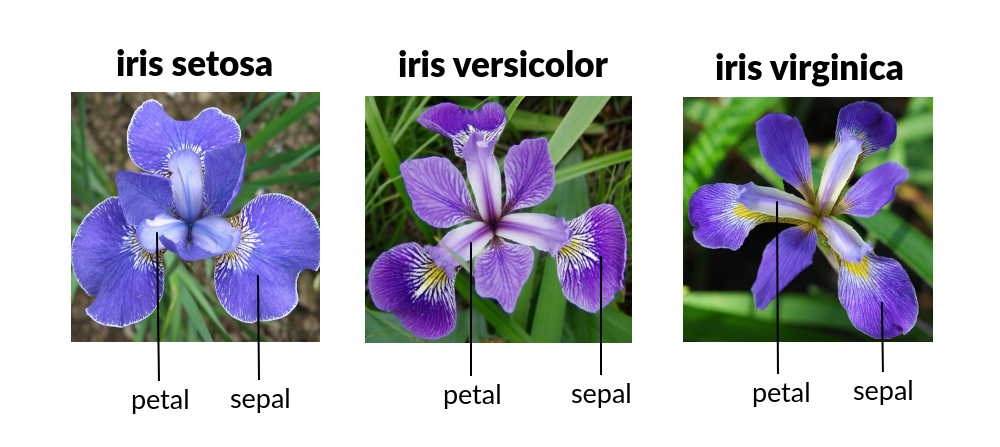

*Imagem*: https://morioh.com/p/eafb28ccf4e3

O arquivo para esse conjunto está no ColabWeb. Porém, o scikit-learn possui uma função cujo trabalho é exatamente carregar o conjunto Iris e disponibilizá-lo para seu notebook.

In [39]:
from sklearn.datasets import load_iris

In [40]:
iris = load_iris()

In [41]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

O conjunto é carregado como um objeto "*bunch*", que significa mais ou menos "amontoado". É um amontoado de características, classes e informações do conjunto!

In [42]:
type(iris)

sklearn.utils._bunch.Bunch

Os dados e as classes estão contidas neste `Bunch` como vetores n-dimensionais do NumPy. Podemos ver todos os atributos que esse objeto contém com o comando `dir`, que explora atributos e métodos de qualquer objeto.

In [43]:
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

**TODO:** explore os atributos do objeto `iris`.

In [44]:
iris['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

**TODO:** encontre os valores médios de todos os atributos e seus desvios padrões.

*DICA:* use os métodos `mean` e `std` da classe `numpy.ndarray`. Especifique o eixo ao longo do qual você quer obter as estatísticas. Por exemplol `axis=0` calcula ao longo das linhas e retorna as médias de cada coluna.

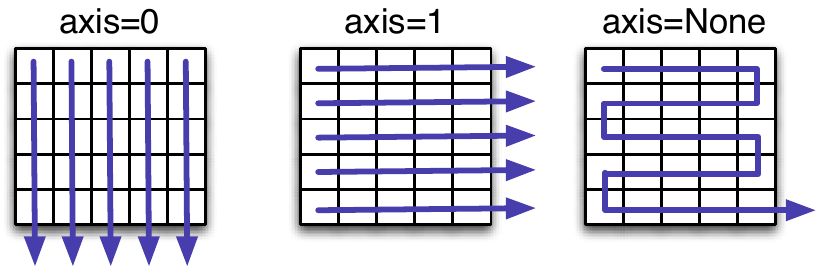
Figura: https://stackoverflow.com/q/64428980/782570

In [45]:
irisArr = iris['data']
irisArr

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [46]:
arr = np.array([])

for j in range(4):
    for i in range(150):
        arr = np.append(arr, irisArr[i][j])
    print('média feat ' + str(j+1))
    print(np.mean(arr))
    print('desvio padrao da feat ' + str(j+1))
    print(np.std(arr))
    print('\n')

média feat 1
5.843333333333334
desvio padrao da feat 1
0.8253012917851409


média feat 2
4.450333333333334
desvio padrao da feat 2
1.5412224224801414


média feat 3
4.219555555555556
desvio padrao da feat 3
1.6498268670857632


média feat 4
3.4644999999999997
desvio padrao da feat 4
1.9738430577598278




**TODO:** descruba os nomes dos rótulos e copie em uma variável chamada `setosa` os exemplos dessa espécie, em uma variável `versicolor` os exemplos dessa espécie e em uma variável `virginica` os exemplos dessa espécie.

In [47]:
setosa = iris['data'][:50]
versicolor = iris['data'][50:100]
virginica = iris['data'][100:]

Se você fez corretamente, então a célula abaixo deve ter como saída os valores 507, 715 e 857.

(*Obs.:* esse procedimento não é importante pra a classificação; apenas um teste das células anteriores)

In [48]:
np.round([setosa.sum(), versicolor.sum(), virginica.sum()])

array([507., 715., 857.])

### Exploração dos dados

Agora que separamos os exemplos nas três classes, podemos estudar um pouco os exemplos dessa base. Uma primeira coisa a ser fazer é analisar os valores médios dos atributos de cada classe.

**TODO:** obtenha os valores médios dos atributos de cada classe.

In [49]:
arr = np.array([])

for j in range(4):
    for i in range(50):
        arr = np.append(arr, setosa[i][j])
    print('média feat ' + str(j+1) + ' setosa')
    print(np.mean(arr))
    print('\n')

média feat 1 setosa
5.006


média feat 2 setosa
4.217


média feat 3 setosa
3.298666666666667


média feat 4 setosa
2.5355000000000003




In [50]:
arr = np.array([])

for j in range(4):
    for i in range(50):
        arr = np.append(arr, versicolor[i][j])
    print('média feat ' + str(j+1) + ' versicolor')
    print(np.mean(arr))
    print('\n')

média feat 1 versicolor
5.936


média feat 2 versicolor
4.353


média feat 3 versicolor
4.322


média feat 4 versicolor
3.5729999999999995




In [51]:
arr = np.array([])

for j in range(4):
    for i in range(50):
        arr = np.append(arr, virginica[i][j])
    print('média feat ' + str(j+1) + ' virginica')
    print(np.mean(arr))
    print('\n')

média feat 1 virginica
6.587999999999998


média feat 2 virginica
4.781


média feat 3 virginica
5.037999999999999


média feat 4 virginica
4.285




Aparentemente, as médias dos atributos são razoavelmente diferentes para cada classe. Podemos confirmar isso gerando um conjunto de gráficos de espalhamento (*scatter plots*).

A biblioteca Seaborn possui uma funcionalidade muito conveniente que é capaz de plotar vários gráficos de espalhamento em pares, mas para isso precisamos que os dados estejam guardados em um `DataFrame`.

Vamos gerar um `DataFrame` com base nas informações de nomes dos atributos que o scikit retornou:

In [52]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Em seguida, podemos acrescentar a classe.

**TODO:** acrescente a classe como a última coluna do `iris_df`, chamando essa coluna de `species`:

In [53]:
Species = np.array([0]*50)
for i in range(50):
    Species = np.append(Species,[1])

for i in range(50):
    Species = np.append(Species,[2])

len(Species)

150

In [54]:
iris_df['species'] = Species
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Feito corretamente, o conteúdo de `iris_df` deverá ser semelhante ao seguinte:

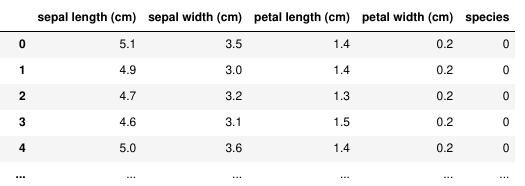

Agora use `sns.pairplot` para produzir os gráficos de espalhamento. O parâmetro `hue` recebe o nome da classe e usa essa informação para escolher as cores e também para não gerar pares de espalhamento com a classe. O parâmetro `palette` recebe uma string que indica ao Seaborn quais cores utilizar para as classes.

In [55]:
import seaborn as sns

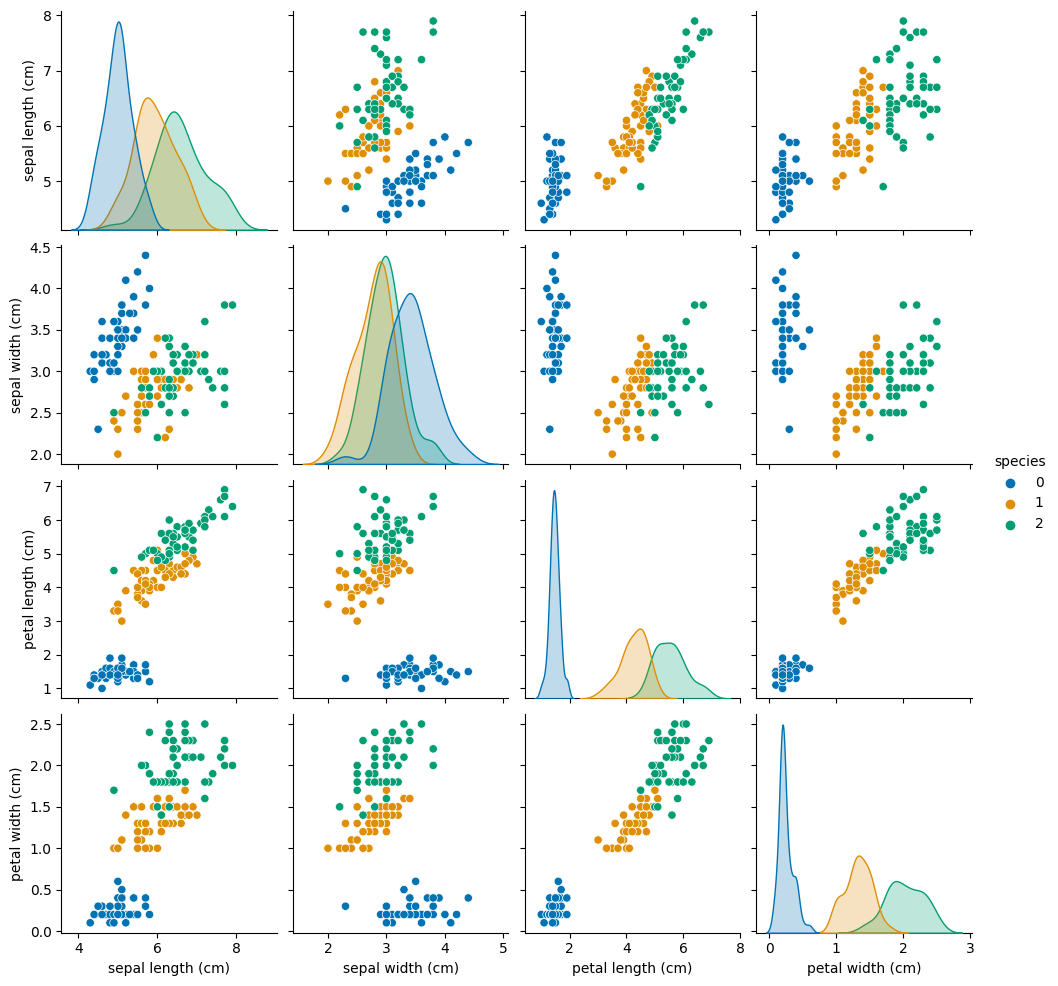

In [56]:
sns.pairplot(iris_df, hue='species', palette='colorblind')

Nas diagonais, você está vendo histogramas dos valores dos atributos para as classes. Como se pode perceber, a classe 0 (setosa) pode ser facilmene separada das demais por qualquer medida de pétala. As classes 1 e 2 (versicolor e virginica) não estão tão visivalmente separadas das demais, mas olhando pares de atributos podemos obter várias separações razoáveis com combinações lineares.

### Treinando o k-NN e calculando o erro empírico... *wait, what*?

Agora podemos treinar o k-NN. Vamos especificar o hiperparâmetro `k=1`.

**TODO:** instanciar um classificador k-NN com a classe `sklearn.neighbors.KNeighborsClassifier`, especificando `n_neighbors=1`.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier(n_neighbors=1)

**TODO:** "treinar" o k-NN nos exemplos de treinamento.

In [59]:
X_train = iris_df.iloc[:,:4]
y_train = iris_df.iloc[:,4:]

In [60]:
knn.fit(X_train, y_train)

/home/mariohn/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=1)

**TODO:** classificar os exemplo de treinamento e calcular o erro empírico

In [61]:
y_pred = knn.predict(X_train)

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
accuracy_score(y_train, y_pred)

1.0

Se você fez corretamente, então obteve que o erro empírico foi zero. O k-NN *sempre* tem erro empírico zero quando k=1.

Por quê?

Vamos testar com outros valores de k... complete o `for` a seguir.

**TODO:** complete o código a seguir (linhas 7, 8 e 11) para calcular os erros empíricos de vários valores do hiperparâmetro `k`.

In [64]:
hyper_k = [3, 5, 7, 9, 11, 13, 15, 20, 25, 50, 100, 149, 150]
erros = np.zeros((len(hyper_k,)))

for i in range(len(hyper_k)):
    k = hyper_k[i]
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    ypred = knn.predict(iris.data)
    erros[i] = 1 - accuracy_score(y_train, ypred)

/home/mariohn/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/mariohn/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/mariohn/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/mariohn/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/mariohn/.local/lib/python3.10/site-packages/sklearn/neighbors/_c

Se você fez corretamente, a célula a seguir deverá mostrar um `DataFrame` contendo os diferentes erros.

In [65]:
pd.DataFrame(erros, columns=['Erro empírico'], index=hyper_k)

,Erro empírico
3,0.040000
5,0.033333
7,0.026667
9,0.020000
11,0.026667
13,0.020000
15,0.013333
20,0.020000
25,0.020000
50,0.060000


Como você pode ver, o desempenho do algoritmo varia conforme o número de vizinhos é alterado. Esse procedimento é bastante semelhante ao que faríamos se estivéssemos tentando selecionar o melhor hiperparâmetro do k-NN, mas existe uma ressalva importante: **não se seleciona hiperparâmetro com o erro empírico**. Isto foi apenas um exemplo. Existem procedimentos apropriados para separar os dados em sub-amostras para encontrar hiperparâmetro, depois treinar e estar o modelo.

## Separação em treino e teste

Ok, então, vai ser em aulas futuras que vamos falar sobre os procedimentos apropriados para encontrar valores  de hiperparâmetros. Mas isso não nos impede de praticar um procedimento simples de separação em treinamento e teste.

Calcular o erro em um conjunto de teste é melhor do que utilizar o erro empírico porque simula o cenário em que a inferência acontecerá com amostras nunca antes vistas.

O nome desse procedimento é ***hold-out***, que pode ser traduzido para o português mais ou menos como *deixar de fora*. No *hold-out*, nós selecionamos uma fração da amostra e reservamos para que seja o conjunto de teste. O *hold-out* só é adequado quando temos uma quantidade grande de exemplos (o que não é o caso dos conjuntos que vimos até agora), mas é o procedimento mais simples. Então vamos usá-lo mesmo assim, ao menos por hoje.&nbsp;&nbsp;:-)

O *hold-out* está dispnível no scikit-learn como a função `sklearn.model_selection.train_test_split`.

In [66]:
from sklearn.model_selection import train_test_split

A função recebe como entrada, pelo menos, a matriz de características. Como nosso problema é supervisionado, também precisamos passar o vetor de classes, senão não conseguiremos associar as classes às características depois.

A separação é feita de maneira aleatória. Para que os experimentos possam ser reproduzidos e todos obtenhamos o mesmo resultado, é interessante especificar uma *semente* para que a sequência de números pseudoaleatórios utilizada pelo scikit seja igual para todos nós.

In [67]:
(X_train, X_test, y_train, y_test) = train_test_split(iris.data, iris.target, random_state=34)

As quatro variáveis de saída guardam, respectivamente, os exemplos de treino e teste, bem como suas classes. Como não especificamos *quantos* exemplos nós queríamos no treino e no teste, o scikit reservou 75% para treino e o restante para teste. Podemos confirmar isso verificando o número de linhas em cada matriz.

In [68]:
(X_train.shape[0], X_test.shape[0])

(112, 38)

Parece certo. Mas, como ficou a distribuição de classes nos dois conjuntos? Podemos usar `numpy.histogram()` para gerar contagem dos valores.

In [69]:
classes_treino = np.histogram(y_train, bins=3)
classes_teste = np.histogram(y_test, bins=3)
len(classes_treino)

2

No treino (vamos dividir pela soma para vermos a porcentagem de cada classe)

In [70]:
classes_treino[0] / classes_treino[0].sum()

array([0.30357143, 0.29464286, 0.40178571])

E no teste...

In [71]:
classes_teste[0] / classes_teste[0].sum()

array([0.42105263, 0.44736842, 0.13157895])

Epa... não parece muito legal... a frequências das classes mudou do treino para o teste. Isso significa que o nosso particionamento não está seguindo a amostragem original.

Faltou **estratificar** o particionamento de modo a garantir que a distribuição das classes no particionamento vai ser aproximadamente igual à do conjunto original.

Podemos fazer isso acrescentando o parâmetro `stratify=y`, no qual `y` é a lista de rótulos, na mesma ordem em que os rótulos foram apresentados para a função.

**TODO:** acrescente o parâmetro `stratify` à chamada de função, passando os rótulos como argumento.

In [72]:
(X_train, X_test, y_train, y_test) = train_test_split(iris.data, iris.target, random_state=34, stratify=iris.target)

**TODO:** Agora repita o procedimento para calcular o número de amostras de cada classe.

In [73]:
classes_treino = np.histogram(y_train, bins=3)
classes_teste = np.histogram(y_test, bins=3)

In [74]:
classes_treino[0] / classes_treino[0].sum()

array([0.33035714, 0.33035714, 0.33928571])

In [75]:
classes_teste[0] / classes_teste[0].sum()

array([0.34210526, 0.34210526, 0.31578947])

Se você fez  corretamente, então cada classe representa aproximadamente 33% das amostras no conjunto de treino e no conjunto de teste (como são poucos exemplos, esse número pode variar um pouco).

### Test

O último passo é testar!

**TODO:** faça o "treinamento" do classificador com k=5 no conjunto `(X_train, y_train)` e depois teste com `(X_test, y_test)`. Calcule o erro.

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)

In [77]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [78]:
ypred_knn = knn.predict(X_test)

In [79]:
1 - accuracy_score(y_test, ypred_knn)

0.02631578947368418

Se você fez corretamente, então o erro encontrado será aproximadamente 0,026.

**TODO bônus**: faça separação em treino e teste do conjunto `play_tennis` e procure um valor de erro para o classificador Naive Bayes categórico.

In [80]:
nb2 = CategoricalNB(alpha=1e-10)

In [81]:
(X_train, X_test, y_train, y_test) = train_test_split(Xenc, yenc, random_state=34, stratify=yenc)

In [82]:
# model fit

nb2.fit(X_train, y_train)

CategoricalNB(alpha=1e-10)

In [83]:
#teste
ypred_train = nb2.predict(X_train)
ypred_test = nb2.predict(X_test)

In [85]:
acc_treino = accuracy_score(ypred_train, y_train)
acc_teste = accuracy_score(ypred_test, y_test)

print(acc_treino)
print(acc_teste)

0.8
0.5


In [87]:
ee1 = 1-acc_teste
ee2 = 1-acc_treino
print('O erro empírico do treino com o naive Bayes categórico é igual a: ' + str(ee2))
print('O erro empírico do teste com o naive Bayes categórico é igual a: ' + str(ee1))

O erro empírico do treino com o naive Bayes categórico é igual a: 0.19999999999999996
O erro empírico do teste com o naive Bayes categórico é igual a: 0.5
